# 사전 준비

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00


In [2]:
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

GPT2_tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',       # 문장 시작토큰
    eos_token='</s>',       # 문장 마지막토큰
    unk_token='<unk>',      # 어휘에 없는 토큰
    pad_token='<pad>',      # 크기 맞추기 토큰
    mask_token='<mask>',     # 마스킹 토큰
)
GPT2_model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')   # 챗봇의 사전학습 모델로는 KoGPT2 사용

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


# 데이터 불러오기
**훈련 데이터**

In [3]:
import pandas as pd

interview_data = pd.read_csv("/content/Interview_Data.csv")

**평가 데이터**

In [4]:
import pandas as pd

dev_interview_data = pd.read_csv("/content/Dev_Interview_Data.csv")

# 텍스트 전처리

In [5]:
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 11.4 MB/s eta 0:00:00


In [6]:
# 회사이름 리스트를 정규표현식으로 변경
def name_regex (file_path):
    with open(file_path) as f:
        names_list = f.read().splitlines()

    for i in range(0, len(names_list)):
        if i == 0:
            names_list[i] = str('(' + names_list[i])
        elif i == (len(names_list)-1):
            names_list[i] = str('|' + names_list[i] + ')')
        else:
            names_list[i] = str('|' + names_list[i])

    names_str = ''.join(names_list)
    return names_str

In [7]:
import re
from soynlp.normalizer import repeat_normalize

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
whitespace_symbol = re.compile(r'[\t\r\n\f\v]+')

In [8]:
def text_preprocess(x, file_path):
    x = pattern.sub(' ', x)                     # 일반적으로 사용하는 특수문자, 영어, 한글제외 공백으로 치환
    x = whitespace_symbol.sub(' ', x)           # space(공백문자)를 제외한 whitespace 문자를 공백으로 치환
    x = re.sub(name_regex(file_path), 'XX', x)  # 회사명 XX로 치환
    x = x.strip()                               # 문자의 시작과 끝에서 공백제거
    x = repeat_normalize(x, num_repeats=2)      # 반목되는 문자의 축약 횟수 2개로 줄임
    return x

In [9]:
# '글자수XX자 XXXByte' 제거
def remove_count_byte(x):
    return re.sub(r'글자수 \d+자 \d{1,3}(,\d{3})*Byte$', '', x)

In [10]:
interview_data.Question = interview_data.Question.apply(
    lambda x: text_preprocess(x, '/content/companies_name.txt'))
interview_data.Answer = interview_data.Answer.apply(
    lambda x: text_preprocess(x, '/content/companies_name.txt'))

In [11]:
interview_data.Answer = interview_data.Answer.apply(remove_count_byte)

In [12]:
dev_interview_data.Question = dev_interview_data.Question.apply(
    lambda x: text_preprocess(x, '/content/Dev_companies_name.txt'))
dev_interview_data.Answer = dev_interview_data.Answer.apply(
    lambda x: text_preprocess(x, '/content/Dev_companies_name.txt'))

# 데이터 구축

In [13]:
import numpy as np
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, docs, tokenizer, max_len):
        super().__init__()
        self.docs = docs
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.bos_id = tokenizer.convert_tokens_to_ids("<s>")
        self.eos_id = tokenizer.convert_tokens_to_ids("</s>")
        self.pad_id = tokenizer.convert_tokens_to_ids("<pad>")

    # padding 및 데이터 size 일치화 함수 (input_ids)
    def add_padding(self, inputs):
        if len(inputs) < self.max_len:
            pad = np.array([self.pad_id]*(self.max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:self.max_len]
        return inputs

    def __len__(self):  
        return len(self.docs)

    def __getitem__(self, idx):
        Q = self.docs.Question[idx]
        A = self.docs.Answer[idx]

        Q_token = [self.bos_id] + self.tokenizer.encode(Q) + [self.eos_id]
        A_token = self.tokenizer.encode(A) + [self.eos_id]
        
        # <s> Q </s> A </s> <pad>...
        input_ids = Q_token + A_token
        input_ids = self.add_padding(input_ids)

        # attention_mask(어텐션마스크) = Q+A 길이 1 + 나머지(패딩) 0
        # token_type_ids(세그먼트 정보) = Q 0 + A 1 + 나머지 0
        if (self.max_len - len(Q_token+A_token)) > 0:
            attention_mask = [1]*(len(Q_token+A_token)) + [0]*(self.max_len - len(Q_token+A_token))
            token_type_ids = [0]*len(Q_token) + [1]*len(A_token) + [0]*(self.max_len - len(Q_token+A_token))
        else:
            attention_mask = [1]*(self.max_len)
            token_type_ids = [0]*len(Q_token) + [1]*(self.max_len - len(A_token))
            attention_mask = self.add_padding(attention_mask)
            token_type_ids = self.add_padding(token_type_ids)

        """
        # A </s> <pad>...
        labels = self.tokenizer.encode(A) + [self.eos_id]
        labels = self.add_padding(labels)
        """

        return {'input_ids': np.array(input_ids, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.int_),
                'token_type_ids': np.array(token_type_ids, dtype=np.int_)}
                # 'labels': np.array(labels, dtype=np.int_)}

**데이터셋 구축**

In [14]:
train_set = DataSet(interview_data, tokenizer=GPT2_tokenizer, max_len=1024)
val_set = DataSet(dev_interview_data, tokenizer=GPT2_tokenizer, max_len=1024)

In [15]:
train_set[0]

{'input_ids': array([    0, 11011,  7244, ...,     3,     3,     3]),
 'attention_mask': array([1, 1, 1, ..., 0, 0, 0]),
 'token_type_ids': array([0, 0, 0, ..., 0, 0, 0])}

**데이터로더 구축**

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, shuffle=False, batch_size=2)
val_dataloader = DataLoader(val_set, shuffle=False, batch_size=2)

# 모델 학습
**모델 파라미터 설정**

In [17]:
import torch

# GPU 가속을 사용할 수 있으면 device를 cuda로 설정하고, 아니면 cpu로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 5
learning_rate = 1e-3
accumulation_steps = 4  # Gradient Accumulation을 위한 스텝 수

eval_steps = len(train_dataloader)

optimizer = torch.optim.Adam(GPT2_model.parameters(), lr=learning_rate)

In [18]:
# 256MB이상의 블록 분할 불가, GPU 메모리 50%이상 사용시 블록 회수를 시작
!PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.5,max_split_size_mb:256

In [19]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [20]:
GPT2_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [21]:
from tqdm.auto import tqdm as tqdm_auto

train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    loss = 0
    total_loss = 0.0
    GPT2_model.train()
    for step, batch in enumerate(tqdm_auto(train_dataloader, mininterval=0.01, leave=True)):
        optimizer.zero_grad()     # 그래디언트 초기화

        inputs = {k: v.to(device) for k, v in batch.items()} 
        outputs = GPT2_model(**inputs, labels=inputs["input_ids"])   # 모형으로 결과 예측

        loss = outputs.loss

        loss = loss / accumulation_steps  # loss를 Gradient Accumulation 스텝 수로 나누기
        loss.backward()     # 역전파

        total_loss += loss.item()
        
         # Gradient Accumulation 스텝 수마다, 마지막 배치때 옵티마이저 업데이트
        if ((step + 1) % accumulation_steps == 0) or ((step + 1) == len(train_dataloader)):
            optimizer.step()
            optimizer.zero_grad()

        if (step + 1) % eval_steps == 0:  # eval_steps 마다 loss를 출력
            with torch.no_grad():   # 학습 X (그래디언트 계산 X)
                val_loss = 0
                GPT2_model.eval()        # 평가모드로 전환

                for val_batch in tqdm_auto(val_dataloader, mininterval=0.01, leave=True):

                    # 배치를 GPU로 복사
                    inputs = {k: v.to(device) for k, v in batch.items()}
                    val_outputs = GPT2_model(**inputs)     # 모형으로 결과 예측

                    val_loss += outputs.loss.item()

                avg_val_loss = val_loss / len(val_dataloader)
                val_loss_list.append(avg_val_loss)
            print('Step %d, validation loss: %.4f' % ((step + 1), avg_val_loss))

        del loss
        del inputs
        del outputs
        gc.collect()
        torch.cuda.empty_cache()

    avg_train_loss = total_loss / (len(train_dataloader)/accumulation_steps)
    torch.cuda.empty_cache()
    print('epoch %d, train loss: %.4f \n' % (epoch, avg_train_loss))
    train_loss_list.append(avg_train_loss)

    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Step 526, validation loss: 1.8049
epoch 0, train loss: 3.4551 



  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Step 526, validation loss: 1.7000
epoch 1, train loss: 2.4811 



  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Step 526, validation loss: 1.7032
epoch 2, train loss: 2.4779 



  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Step 526, validation loss: 1.7051
epoch 3, train loss: 2.4658 



  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Step 526, validation loss: 1.6349
epoch 4, train loss: 2.4371 



In [22]:
import matplotlib.pyplot as plt

epoch_list = []

for i in range(1, epochs+1):
    epoch_list.append(i)

def plot_loss(epoch_list, train_loss_list, val_loss_list):
    plt.plot(epoch_list, train_loss_list, marker='o')
    plt.plot(epoch_list, val_loss_list, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

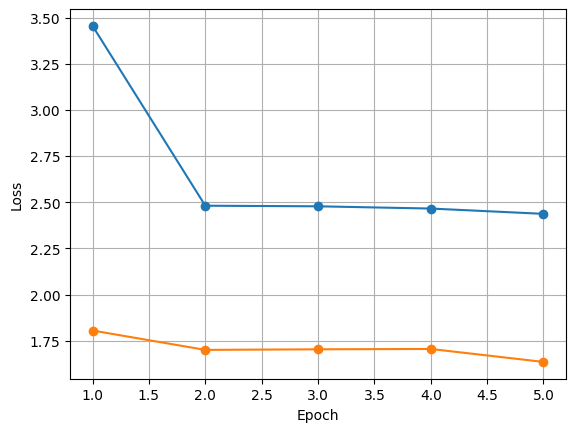

In [23]:
plot_loss(epoch_list, train_loss_list, val_loss_list)

In [24]:
while 1:
    document = input("질문 입력 > \n").strip()
    # quit 입력시 종료
    if document == "quit":
        break
    
    input_ids = GPT2_tokenizer.encode(document, return_tensors='pt').to(device)

    with torch.no_grad():
        gen_ids = GPT2_model.generate(
                input_ids,
                do_sample=True,
                max_length=30,
                top_p=0.5,
                top_k=5,
                repetition_penalty=1.0,
                no_repeat_ngram_size=2,
                temperature=0.5,
                )
        generated = GPT2_tokenizer.decode(gen_ids[0])
            
        print(f'생성 결과 > {generated}')

질문 입력 > 
지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.
생성 결과 > 지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.<pad><pad>적,)<pad></s>
질문 입력 > 
지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.
생성 결과 > 지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.<pad><pad>자<pad></s>
질문 입력 > 
지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.
생성 결과 > 지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.<pad><pad>자<pad></s>
질문 입력 > 
지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.
생성 결과 > 지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.<pad><pad>적,BI자)<pad></s>
질문 입력 > 
지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.
생성 결과 > 지원동기와 입사 후 커리어 목표를 구체적으로 기술해주세요.<pad><pad>자<pad></s>
질문 입력 > 
quit
